# Test Case 8 - Two Inductances

In [1]:
from CircuitCalculator.Circuit.state_space_model import state_space_model
from CircuitCalculator.Circuit.circuit import Circuit, transform_circuit
from CircuitCalculator.Circuit import components as cmp
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

## Setup Circuit

In [2]:
R1, R2, R3 = 10, 20, 30
L1, L2 = 0.1, 0.2
V0 = 5
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=V0, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.inductance(id='L1', L=L1, nodes=('2', '3')),
    cmp.resistor(id='R2', R=R2, nodes=('3', '0')),
    cmp.inductance(id='L2', L=L2, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])

In [3]:
network=transform_circuit(circuit, w=0)

In [4]:
def step(t: np.ndarray) -> np.ndarray:
    return np.heaviside(t, 1)

In [5]:
t_max = 0.02
t0 = 0.001
Ts = t_max/1000
t = np.arange(0, t_max, Ts)
V = V0*step(t-t0)

In [6]:
import itertools
from CircuitCalculator.Network.NodalAnalysis.label_mapping import default_node_mapper
node_mapping = default_node_mapper(network)
def element_incidence_matrix(values: dict[str, float]) -> np.ndarray:
    Delta = np.zeros((len(values), node_mapping.N))
    for (k, value), (i_label) in itertools.product(enumerate(values), node_mapping):
        if i_label == network[value].node1:
            Delta[k][node_mapping(i_label)] = +1
        if i_label == network[value].node2:
            Delta[k][node_mapping(i_label)] = -1
    return Delta

In [7]:
from CircuitCalculator.Network.NodalAnalysis.node_analysis import *
import CircuitCalculator.Network.NodalAnalysis.label_mapping as map
from numpy.linalg import inv
voltage_source_mapper = map.alphabetic_voltage_source_mapper
def element_incidence_matrix(values: dict[str, float]) -> np.ndarray:
    Delta = np.zeros((len(values), node_mapping.N))
    for (k, value), (i_label) in itertools.product(enumerate(values), node_mapping):
        if i_label == network[value].node1:
            Delta[k][node_mapping(i_label)] = +1
        if i_label == network[value].node2:
            Delta[k][node_mapping(i_label)] = -1
    return np.hstack((Delta, np.zeros((Delta.shape[0], voltage_source_mapper(network).N))))

In [8]:
l_labels = {'L1': L1, 'L2': L2}

# Y = create_node_matrix_from_network(network)
A_tilde = nodal_analysis_coefficient_matrix(network).real

source_mapping = map.filter(map.default_source_mapper(network), lambda x: x not in l_labels)
Qi = source_incidence_matrix(
        network=network)

source_mapping_all = map.default_source_mapper(network)
voltage_source_mapping = map.filter(voltage_source_mapper(network), lambda x: x not in l_labels)
inductance_mapping = map.filter(voltage_source_mapper(network), lambda x: x in l_labels)
voltage_source_mapping_all = voltage_source_mapper(network)

Q = np.zeros((voltage_source_mapping_all.N, voltage_source_mapping_all.N), dtype=int)
for i in voltage_source_mapping_all.values:
    Q[i][i] = 1
Q = np.vstack((np.hstack( (Qi, np.zeros((Qi.shape[0], Q.shape[1]) ))),
               np.hstack( (np.zeros((Q.shape[0], Qi.shape[1])), Q) )))

QS = Q[:,source_mapping.values]
QL = Q[:,inductance_mapping.values]

# QL = np.zeros((6, inductance_mapping.N), dtype=int)
# for l in inductance_mapping:
#     QL[node_mapping.N+inductance_mapping[l]][inductance_mapping[l]] = 1

L_inv = np.diag([1/L for L in l_labels.values()])
print(L_inv)

A = L_inv@inv(QL.T@inv(A_tilde)@QL)
B = -A @ QL.T@inv(A_tilde)@QS
print(A)
print(B)

C = inv(A_tilde)@QL@inv(L_inv)@A
D = inv(A_tilde)@(QS+QL@inv(L_inv)@B)
print(C)
print(D)

[[10.  0.]
 [ 0.  5.]]
[[-300.  200.]
 [ 100. -100.]]
[[ 1.00000000e+01]
 [-5.10702591e-16]]
[[ 0.00000000e+00  0.00000000e+00]
 [-1.00000000e+01  1.02140518e-15]
 [ 2.00000000e+01 -2.00000000e+01]
 [ 1.00000000e+00  4.21884749e-17]
 [ 2.69784195e-16  1.00000000e+00]
 [-1.00000000e+00 -4.21884749e-17]]
[[ 1.00000000e+00]
 [ 1.00000000e+00]
 [-1.02140518e-16]
 [-1.38777878e-17]
 [-1.38777878e-17]
 [ 1.38777878e-17]]


In [9]:
sys = signal.StateSpace(A, B, C, D)
tout, yout, out = signal.lsim(sys, V, t)

print(A)
print(B)

[[-300.  200.]
 [ 100. -100.]]
[[ 1.00000000e+01]
 [-5.10702591e-16]]


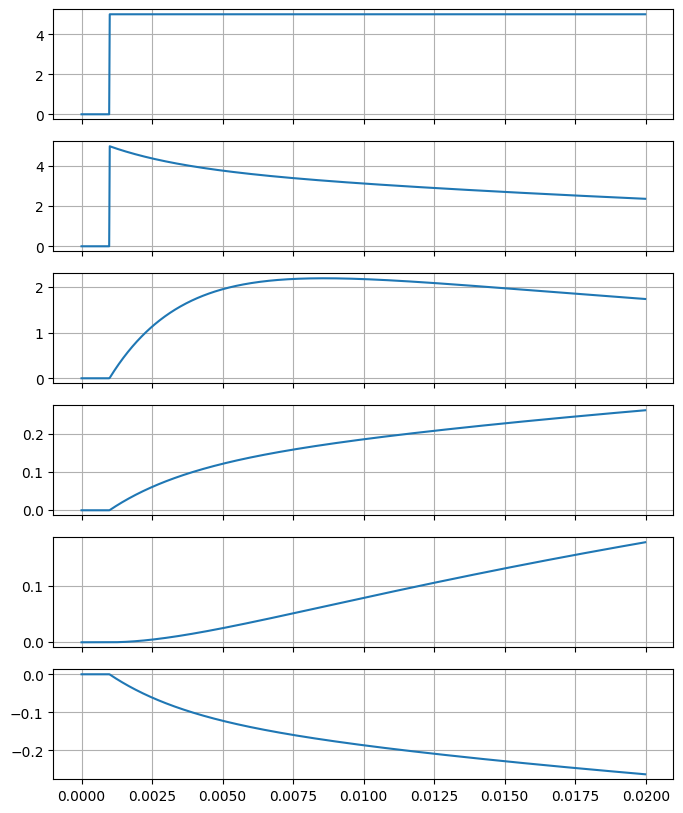

In [15]:
_, ax = plt.subplots(nrows=6, sharex=True, figsize=(8, 10))

ax[0].plot(tout, yout[:,0])
ax[0].grid(True)
# ax[0].set_yticks(np.arange(0, 0.28, 0.02))

ax[1].plot(tout, yout[:,1])
ax[1].grid(True)
# ax[1].set_yticks(np.arange(0, 0.20, 0.02))

ax[2].plot(tout, yout[:,2])
ax[2].grid(True)

ax[3].plot(tout, yout[:,3])
ax[3].grid(True)

ax[4].plot(tout, yout[:,4])
ax[4].grid(True)

ax[5].plot(tout, yout[:,5])
ax[5].grid(True)